<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/Dll30_DZ7_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Рекуррентные сети-2»

# Задание 1.

Cгенерировать последовательности, которые бы состояли из символов цифр от 0 до 9 и формировались следующим образом: X - последовательность цифр, каждая из которых выбирается случайным образом из диапазона от 0 до 9,  y(0)=x(0), y(i) =x(0) + x(i). Если y(i) >=10, y(i) = y(i)-10
Научить модель предсказывать y(i) по x(i). Попробовать RNN, LSTM, GRU и последовательности длиной  [25, 75, 150]


## Импорт библиотек

In [1]:
import torch as tr
import copy
import math
import time

import torch
from torch import nn
import re
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

In [2]:
import os
import sys
from google.colab import drive

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

In [4]:
dev = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
if dev.type == 'cuda': print('work on', tr.cuda.get_device_name(0))
else: print('work on CPU')

work on Tesla T4


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Вспомогательные функции

In [6]:
def f(x):
  """генерация последовательности цифр y"""
  return (x + x[:,0:1]) % 10

In [7]:
def asMinutes(s):
    """Вспомогательная функция перевода секунд  в минуты"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """ длительность итерации обучения"""
    # now = time()
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [8]:
def showPlot(points1, points2, n_iters, print_every, title):
    """Визуализация обучения"""
    fig = plt.figure(figsize=(4,2))
    ax = fig.add_subplot(1, 1, 1)
    xdata = [i for i in range(print_every, n_iters+print_every, print_every)]
    ax.plot(xdata, points1, color='tab:blue')
    ax.plot(xdata, points2, color='tab:orange')
    ax.set_title(title)
    plt.show()

##2. Базовая архитектура RNN

In [9]:
class rnn1(tr.nn.Module):
    def __init__(self, n_classes, embedding_size, hidden_size, num_layers, rnn_type):
        super().__init__()
        self.emb = tr.nn.Embedding(n_classes, embedding_size)
        self.rnn = rnn_type(embedding_size, hidden_size, num_layers, batch_first = True)
        self.lin = tr.nn.Linear(hidden_size, n_classes)
    def forward(self, input):
        r = self.emb(input)
        r = self.rnn(r)[0]
        r = self.lin(r).squeeze()
        return r

##3. Входящие настройки RNN

In [10]:
n_iters        = 5000
n_classes      = 10
embedding_size = 10
hidden_size    = 50
num_layers     = 1
batch_size     = 100
seq_len        = 100
loss_best      = 10**10
learn_rate     = 0.001
rnn_list      = [tr.nn.RNN, tr.nn.LSTM, tr.nn.GRU]
s_l_list = [25, 75, 150] # Это длины последовательностей
print_every   = 500

##4. Эксперименты - анализ влияния размерности входного тензора и типа RNN ячейки на качество моделей RNN (loss, accuracy, learning time)

In [ ]:
x = tr.randint(n_classes, (batch_size, 25))
y = f(x)
print(x[0].shape,y[0].shape) # Пример исходных данных - x и y - батчи из 100 тензоров, каждый по 25 элементоа

torch.Size([25]) torch.Size([25])


MAX_LEN = 25 rnnClass = RNN
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3009 0.1221 2.3005 0.1217
(200 4%) 2.2908 0.1363 2.2898 0.1372
(300 6%) 2.2786 0.1350 2.2783 0.1367
(400 8%) 2.2602 0.1357 2.2597 0.1362
(500 10%) 2.2431 0.1371 2.2432 0.1352
(600 12%) 2.2303 0.1355 2.2300 0.1357
(700 14%) 2.2216 0.1358 2.2215 0.1354
(800 16%) 2.2158 0.1364 2.2157 0.1350
(900 18%) 2.2115 0.1370 2.2117 0.1367
(1000 20%) 2.2085 0.1368 2.2077 0.1367
(1100 22%) 2.2040 0.1382 2.2042 0.1381
(1200 24%) 2.1979 0.1424 2.1981 0.1430
(1300 26%) 2.0733 0.2020 2.0712 0.2033
(1400 28%) 1.8211 0.2655 1.8220 0.2618
(1500 30%) 1.4741 0.3563 1.4669 0.3595
(1600 32%) 1.2055 0.4342 1.2029 0.4332
(1700 34%) 1.0779 0.4424 1.0719 0.4450
(1800 36%) 1.0219 0.4556 1.0173 0.4561
(1900 38%) 0.8992 0.5090 0.8935 0.5096
(2000 40%) 0.7997 0.5208 0.7979 0.5207
(2100 42%) 0.7630 0.5227 0.7628 0.5217
(2200 44%) 0.7415 0.5192 0.7406 0.5220
(2300 46%) 0.7250 0.5204 0.7253 0.5206
(2400 48%) 0.7152 0.5205 0.7156 0.5192
(2500 50%) 0.7072 0.5204 0.7072 0.5209
(2600 52%) 0.7014 0.5207 0.7015 0.5207

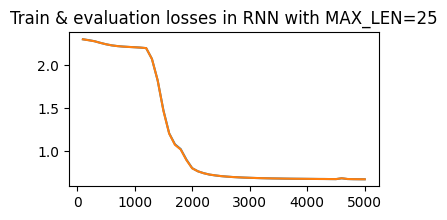

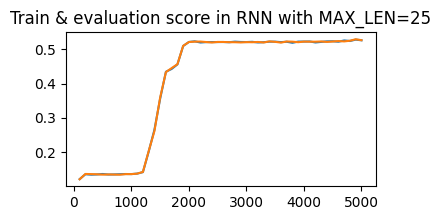

MAX_LEN = 25 rnnClass = LSTM
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3008 0.1168 2.3008 0.1158
(200 4%) 2.2949 0.1308 2.2952 0.1287
(300 6%) 2.2809 0.1330 2.2810 0.1322
(400 8%) 2.1250 0.2108 2.1200 0.2151
(500 10%) 1.4841 0.4089 1.4725 0.4192
(600 12%) 1.0236 0.6217 1.0161 0.6290
(700 14%) 0.6026 0.8189 0.6028 0.8170
(800 16%) 0.3338 0.9531 0.3323 0.9541
(900 18%) 0.1621 0.9991 0.1608 0.9993
(1000 20%) 0.0937 0.9996 0.0932 0.9997
(1100 22%) 0.0616 0.9999 0.0616 0.9999
(1200 24%) 0.0439 1.0000 0.0436 1.0000
(1300 26%) 0.0328 1.0000 0.0328 1.0000
(1400 28%) 0.0258 0.9999 0.0255 1.0000
(1500 30%) 0.0206 1.0000 0.0206 1.0000
(1600 32%) 0.0167 1.0000 0.0169 0.9999
(1700 34%) 0.0168 0.9997 0.0161 0.9998
(1800 36%) 0.0137 0.9999 0.0132 1.0000
(1900 38%) 0.0110 1.0000 0.0110 1.0000
(2000 40%) 0.0095 1.0000 0.0095 1.0000
(2100 42%) 0.0083 1.0000 0.0083 1.0000
(2200 44%) 0.0073 1.0000 0.0073 1.0000
(2300 46%) 0.0065 1.0000 0.0065 1.0000
(2400 48%) 0.0058 1.0000 0.0058 1.0000
(2500 50%) 0.0053 1.0000 0.0053 1.0000
(2600 52%) 0.0047 1.0000 0.0048 1.0000

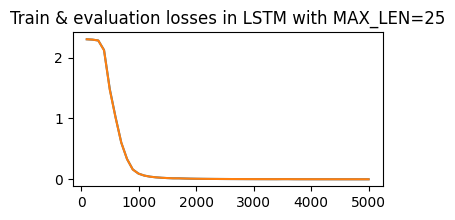

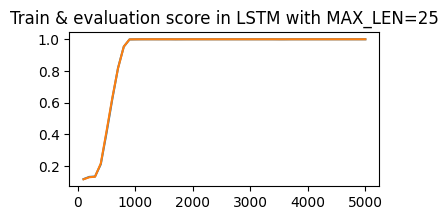

MAX_LEN = 25 rnnClass = GRU
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3003 0.1237 2.2997 0.1236
(200 4%) 2.2930 0.1353 2.2934 0.1356
(300 6%) 2.2793 0.1398 2.2789 0.1396
(400 8%) 2.1511 0.1951 2.1475 0.1939
(500 10%) 1.6247 0.2807 1.6224 0.2799
(600 12%) 1.3739 0.4177 1.3704 0.4174
(700 14%) 0.8932 0.7974 0.8876 0.8032
(800 16%) 0.4086 0.9919 0.4033 0.9928
(900 18%) 0.1914 0.9994 0.1909 0.9994
(1000 20%) 0.1121 1.0000 0.1116 1.0000
(1100 22%) 0.0750 1.0000 0.0746 1.0000
(1200 24%) 0.0550 1.0000 0.0548 1.0000
(1300 26%) 0.0428 1.0000 0.0425 1.0000
(1400 28%) 0.0344 1.0000 0.0342 1.0000
(1500 30%) 0.0282 1.0000 0.0282 1.0000
(1600 32%) 0.0236 1.0000 0.0237 1.0000
(1700 34%) 0.0202 1.0000 0.0201 1.0000
(1800 36%) 0.0189 0.9999 0.0183 1.0000
(1900 38%) 0.0160 1.0000 0.0159 1.0000
(2000 40%) 0.0138 1.0000 0.0139 1.0000
(2100 42%) 0.0122 1.0000 0.0122 1.0000
(2200 44%) 0.0109 1.0000 0.0109 1.0000
(2300 46%) 0.0098 1.0000 0.0098 1.0000
(2400 48%) 0.0088 1.0000 0.0088 1.0000
(2500 50%) 0.0080 1.0000 0.0079 1.0000
(2600 52%) 0.0072 1.0000 0.0072 1.0000

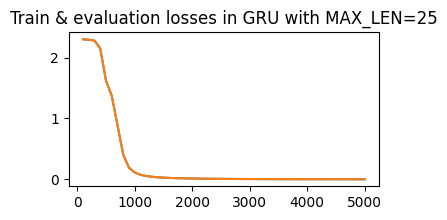

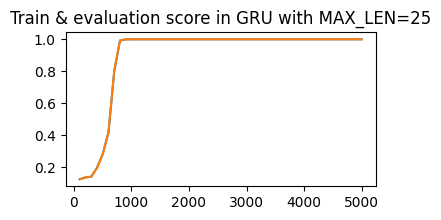

MAX_LEN = 75 rnnClass = RNN
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3045 0.1018 2.3043 0.1031
(200 4%) 2.3018 0.1068 2.3018 0.1053
(300 6%) 2.3003 0.1077 2.2999 0.1073
(400 8%) 2.2985 0.1079 2.2986 0.1080
(500 10%) 2.2967 0.1096 2.2968 0.1101
(600 12%) 2.2951 0.1100 2.2955 0.1089
(700 14%) 2.2933 0.1119 2.2939 0.1098
(800 16%) 2.2922 0.1104 2.2918 0.1114
(900 18%) 2.2899 0.1114 2.2901 0.1117
(1000 20%) 2.2877 0.1112 2.2878 0.1107
(1100 22%) 2.2852 0.1120 2.2852 0.1124
(1200 24%) 2.2830 0.1121 2.2830 0.1125
(1300 26%) 2.2805 0.1116 2.2807 0.1122
(1400 28%) 2.2784 0.1121 2.2787 0.1111
(1500 30%) 2.2768 0.1129 2.2771 0.1120
(1600 32%) 2.2757 0.1099 2.2755 0.1121
(1700 34%) 2.2745 0.1112 2.2743 0.1125
(1800 36%) 2.2733 0.1116 2.2733 0.1122
(1900 38%) 2.2722 0.1128 2.2721 0.1128
(2000 40%) 2.2712 0.1126 2.2713 0.1143
(2100 42%) 2.2699 0.1124 2.2697 0.1125
(2200 44%) 2.0987 0.1776 2.0930 0.1772
(2300 46%) 1.7785 0.2138 1.7785 0.2112
(2400 48%) 1.6842 0.2133 1.6828 0.2136
(2500 50%) 1.6475 0.2207 1.6441 0.2191
(2600 52%) 1.6929 0.2142 1.6872 0.2149

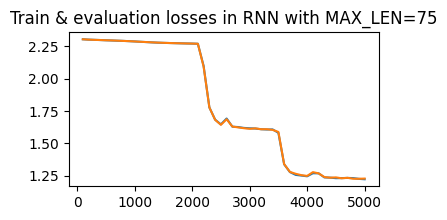

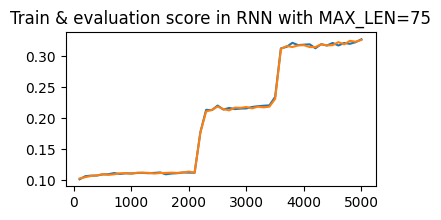

MAX_LEN = 75 rnnClass = LSTM
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3029 0.1019 2.3031 0.1012
(200 4%) 2.3020 0.1084 2.3021 0.1083
(300 6%) 2.3016 0.1083 2.3016 0.1089
(400 8%) 2.3005 0.1104 2.3008 0.1096
(500 10%) 2.2988 0.1100 2.2985 0.1120
(600 12%) 2.2953 0.1121 2.2954 0.1110
(700 14%) 2.2898 0.1143 2.2891 0.1157
(800 16%) 2.0048 0.2056 2.0047 0.2038
(900 18%) 1.7653 0.2162 1.7669 0.2129
(1000 20%) 1.5580 0.3005 1.5553 0.3011
(1100 22%) 1.3523 0.3367 1.3517 0.3340
(1200 24%) 1.2229 0.4092 1.2191 0.4136
(1300 26%) 1.0370 0.5329 1.0315 0.5359
(1400 28%) 0.9135 0.5926 0.9101 0.5970
(1500 30%) 0.7320 0.7070 0.7266 0.7098
(1600 32%) 0.5629 0.7785 0.5606 0.7800
(1700 34%) 0.4318 0.8381 0.4314 0.8390
(1800 36%) 0.2786 0.9029 0.2769 0.9048
(1900 38%) 0.2271 0.9057 0.2224 0.9087
(2000 40%) 0.1943 0.9279 0.1928 0.9276
(2100 42%) 0.0911 0.9958 0.0903 0.9962
(2200 44%) 0.0571 0.9991 0.0562 0.9992
(2300 46%) 0.0437 0.9995 0.0432 0.9996
(2400 48%) 0.0348 0.9996 0.0353 0.9996
(2500 50%) 0.0289 0.9998 0.0287 0.9998
(2600 52%) 0.0244 0.9998 0.0250 0.9996

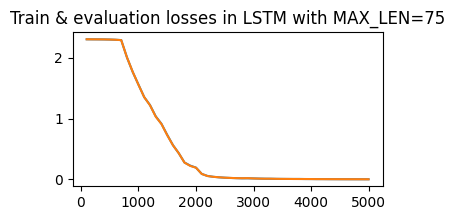

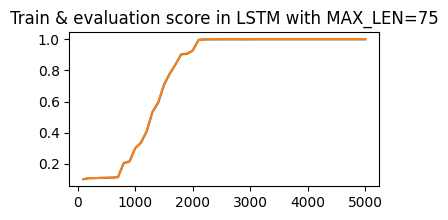

MAX_LEN = 75 rnnClass = GRU
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3034 0.1008 2.3030 0.1017
(200 4%) 2.3019 0.1082 2.3020 0.1064
(300 6%) 2.3014 0.1124 2.3012 0.1115
(400 8%) 2.3010 0.1113 2.3007 0.1118
(500 10%) 2.2999 0.1117 2.2999 0.1124
(600 12%) 2.2985 0.1126 2.2991 0.1120
(700 14%) 2.2963 0.1136 2.2964 0.1144
(800 16%) 2.2587 0.1482 2.2583 0.1470
(900 18%) 1.8048 0.2302 1.8014 0.2323
(1000 20%) 1.2570 0.4316 1.2490 0.4353
(1100 22%) 0.8191 0.5064 0.8181 0.5068
(1200 24%) 0.7364 0.5081 0.7360 0.5092
(1300 26%) 0.7139 0.5137 0.7139 0.5131
(1400 28%) 0.6968 0.5488 0.6967 0.5476
(1500 30%) 0.6635 0.6087 0.6638 0.6065
(1600 32%) 0.6024 0.7075 0.6039 0.7048
(1700 34%) 0.4840 0.8675 0.4845 0.8682
(1800 36%) 0.3154 0.9685 0.3145 0.9688
(1900 38%) 0.1846 0.9956 0.1833 0.9957
(2000 40%) 0.1145 0.9982 0.1130 0.9982
(2100 42%) 0.0770 0.9994 0.0762 0.9995
(2200 44%) 0.0562 0.9997 0.0559 0.9997
(2300 46%) 0.0426 0.9999 0.0427 1.0000
(2400 48%) 0.0339 1.0000 0.0337 1.0000
(2500 50%) 0.0275 1.0000 0.0276 1.0000
(2600 52%) 0.0231 1.0000 0.0230 1.0000

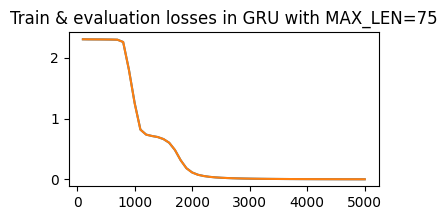

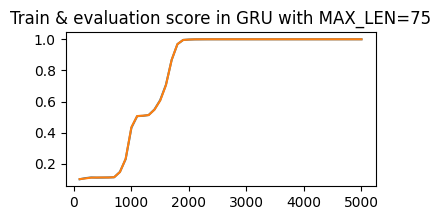

MAX_LEN = 150 rnnClass = RNN
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3052 0.1018 2.3048 0.1036
(200 4%) 2.3029 0.1015 2.3023 0.1039
(300 6%) 2.3021 0.1038 2.3017 0.1046
(400 8%) 2.3017 0.1034 2.3017 0.1037
(500 10%) 2.3013 0.1029 2.3013 0.1033
(600 12%) 2.3007 0.1036 2.3006 0.1038
(700 14%) 2.2996 0.1063 2.2997 0.1049
(800 16%) 2.2990 0.1061 2.2990 0.1049
(900 18%) 2.2981 0.1050 2.2982 0.1055
(1000 20%) 2.2972 0.1063 2.2975 0.1046
(1100 22%) 2.2965 0.1061 2.2964 0.1051
(1200 24%) 2.2953 0.1070 2.2955 0.1044
(1300 26%) 2.2946 0.1053 2.2945 0.1047
(1400 28%) 2.2936 0.1065 2.2936 0.1057
(1500 30%) 2.2925 0.1050 2.2925 0.1061
(1600 32%) 2.2917 0.1054 2.2916 0.1074
(1700 34%) 2.2909 0.1059 2.2908 0.1077
(1800 36%) 2.2900 0.1065 2.2903 0.1059
(1900 38%) 2.2895 0.1068 2.2895 0.1056
(2000 40%) 2.2891 0.1057 2.2890 0.1070
(2100 42%) 2.2887 0.1063 2.2887 0.1058
(2200 44%) 2.2883 0.1059 2.2883 0.1055
(2300 46%) 2.2880 0.1058 2.2880 0.1052
(2400 48%) 2.2877 0.1059 2.2877 0.1068
(2500 50%) 2.2873 0.1056 2.2873 0.1053
(2600 52%) 2.2871 0.1063 2.2871 0.1052

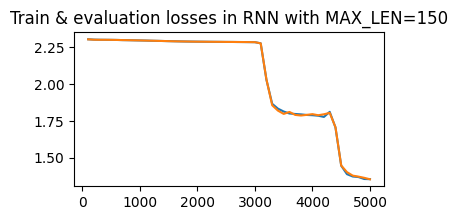

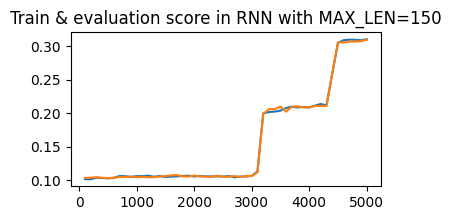

MAX_LEN = 150 rnnClass = LSTM
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3032 0.1007 2.3033 0.1014
(200 4%) 2.3028 0.0995 2.3027 0.1013
(300 6%) 2.3027 0.1004 2.3025 0.1030
(400 8%) 2.3023 0.1050 2.3024 0.1042
(500 10%) 2.3024 0.1043 2.3022 0.1046
(600 12%) 2.3021 0.1040 2.3020 0.1044
(700 14%) 2.3016 0.1062 2.3016 0.1059
(800 16%) 2.3013 0.1053 2.3012 0.1046
(900 18%) 2.3008 0.1038 2.3009 0.1035
(1000 20%) 2.2997 0.1060 2.2995 0.1079
(1100 22%) 2.2985 0.1058 2.2983 0.1066
(1200 24%) 2.2967 0.1075 2.2969 0.1040
(1300 26%) 2.2949 0.1059 2.2949 0.1058
(1400 28%) 2.2928 0.1067 2.2930 0.1059
(1500 30%) 2.2236 0.1458 2.2211 0.1446
(1600 32%) 1.7770 0.2025 1.7721 0.2042
(1700 34%) 1.6509 0.2052 1.6456 0.2080
(1800 36%) 1.6341 0.2065 1.6391 0.2078
(1900 38%) 1.4790 0.2724 1.4720 0.2746
(2000 40%) 1.1656 0.3823 1.1651 0.3858
(2100 42%) 0.9808 0.4343 0.9833 0.4359
(2200 44%) 0.7504 0.5016 0.7487 0.5033
(2300 46%) 0.7150 0.5028 0.7149 0.5023
(2400 48%) 0.7059 0.5050 0.7058 0.5050
(2500 50%) 0.7013 0.5055 0.7014 0.5029
(2600 52%) 0.6986 0.5037 0.6989 0.5017

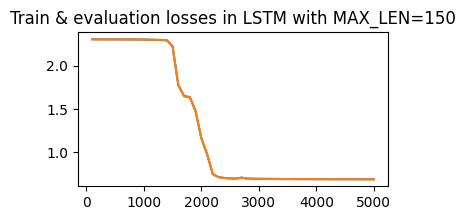

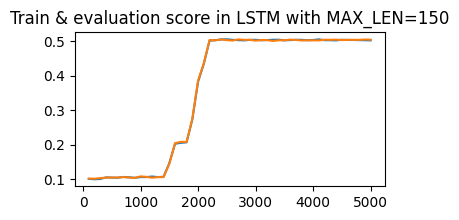

MAX_LEN = 150 rnnClass = GRU
Пройдено эпох:


  0%|          | 0/5000 [00:00<?, ?it/s]

(100 2%) 2.3030 0.1025 2.3035 0.1011
(200 4%) 2.3026 0.1020 2.3026 0.1030
(300 6%) 2.3023 0.1026 2.3023 0.1043
(400 8%) 2.3022 0.1039 2.3025 0.1031
(500 10%) 2.3019 0.1048 2.3018 0.1051
(600 12%) 2.3017 0.1050 2.3019 0.1031
(700 14%) 2.3014 0.1054 2.3014 0.1056
(800 16%) 2.3009 0.1068 2.3010 0.1058
(900 18%) 2.3004 0.1063 2.3002 0.1083
(1000 20%) 2.2993 0.1075 2.2995 0.1072
(1100 22%) 2.2969 0.1142 2.2968 0.1149
(1200 24%) 1.8895 0.2070 1.8849 0.2078
(1300 26%) 1.2136 0.4288 1.2072 0.4313
(1400 28%) 0.8001 0.5015 0.7992 0.5011
(1500 30%) 0.7328 0.5042 0.7327 0.5050
(1600 32%) 0.7143 0.5050 0.7140 0.5065
(1700 34%) 0.7053 0.5145 0.7050 0.5163
(1800 36%) 0.6909 0.5595 0.6907 0.5632
(1900 38%) 0.6509 0.6160 0.6489 0.6208
(2000 40%) 0.5793 0.7112 0.5771 0.7147
(2100 42%) 0.4588 0.8195 0.4550 0.8227
(2200 44%) 0.2906 0.9519 0.2897 0.9527
(2300 46%) 0.1632 0.9886 0.1609 0.9887
(2400 48%) 0.1005 0.9943 0.1010 0.9942
(2500 50%) 0.0664 0.9977 0.0655 0.9978
(2600 52%) 0.0471 0.9988 0.0468 0.9987

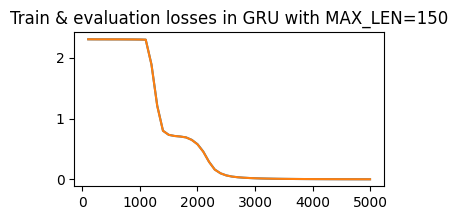

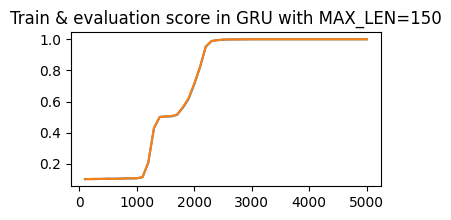

In [ ]:
df = pd.DataFrame(columns = ['rnnClass', 'max_len','time', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

for i in s_l_list:
    for rnn_type in rnn_list:
        print('======================================')
        print(f'MAX_LEN = {i} rnnClass = {rnn_type.__name__}')
        print('======================================')
        model = rnn1(n_classes, embedding_size, hidden_size, num_layers, rnn_type).to(dev)
        opt   = tr.optim.Adam(model.parameters(), lr=learn_rate)
        crit  = tr.nn.CrossEntropyLoss()
        t_a, t_l, v_a, v_l = [], [], [], []
        print('Пройдено эпох:')
        start = time.time()
        for iter in tqdm(range(1,(n_iters+1))):
            print_train_loss = 0
            print_val_loss = 0
            print_train_acc = 0
            print_val_acc = 0

            # train loop
            model.train()
            x = tr.randint(n_classes, (batch_size, i)).to(dev)
            y = f(x)
            opt.zero_grad()
            pred = model(x) # torch.Size([100, 25, 10])
            train_acc = (y == pred.argmax(dim=-1)).sum() / tr.tensor(y.shape).prod()
            train_loss = crit(pred.reshape(-1, n_classes), y.flatten()).to(dev)  #
            train_loss.backward()
            opt.step()

            # evaluation loop
            model.eval()
            x = tr.randint(n_classes, (batch_size, i)).to(dev)
            y = f(x)
            pred = model(x)
            val_loss = crit(pred.reshape(-1, n_classes), y.flatten())
            val_acc = (y == pred.argmax(dim=-1)).sum() / tr.tensor(y.shape).prod()


            print_train_loss += train_loss
            print_val_loss += val_loss
            print_train_acc += train_acc
            print_val_acc += val_acc

            if iter % print_every == 0:

                train_loss_avg = print_train_loss / print_every
                t_l.append(train_loss_avg.detach().numpy())

                val_loss_avg = print_val_loss / print_every
                v_l.append(val_loss_avg.detach().numpy())

                train_acc_avg = print_train_acc / print_every
                t_a.append(train_acc_avg.detach().numpy())

                val_acc_avg = print_val_acc / print_every
                v_a.append(val_acc_avg.detach().numpy())

                print('(%d %d%%) %.4f %.4f %.4f %.4f' % (iter, iter / n_iters * 100, train_loss_avg, train_acc_avg, val_loss_avg, val_acc_avg))

        print('Learning_time:', time.time() - start)
        showPlot(t_l, v_l, n_iters,f'Train & evaluation losses in {rnn_type.__name__} with MAX_LEN={i}')
        print()
        showPlot(t_a, v_a, n_iters, f'Train & evaluation score in {rnn_type.__name__} with MAX_LEN={i}')
        df.loc[len(df) + 1] = [rnn_type.__name__, i, time.time() - start, t_l[-1], t_a[-1], v_l[-1], v_a[-1]]
        # df_2.loc[rnn_type.__name__, i] = round(val_acc.item(),5)

##5. Выводы

###5.1. Функция потерь

In [ ]:
pd.pivot_table(df[['rnnClass', 'max_len','val_loss']],
               index=['rnnClass'],
               values=["val_loss"],
               columns=["max_len"]).style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues')

При обучении в течение 5000 эпох наименьшие потери наблюдаются в случае использования LSTM ячейки при минимальной длине последовательности.

Во всех остальных экспериментах наилучшие результаты  в части потерь достигаютсм при использовании в архитектуре модели GRU ячейки. При этом с ростом длины последовательности закономерно происходит и рост потерь.

### 5.2. Accuracy

In [ ]:
pd.pivot_table(df[['rnnClass', 'max_len','val_acc']] ,
               index=["rnnClass"],
               values=["val_acc"],
               columns=["max_len"]).style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues')

При выбранном числе эпох благодаря GRU ячейкам при всех длинах последовательностей удалось достигнуть максимальной точности модели.

RNN ячейки показали невысокую точность - около 50%.

Промежуточное положение заняли модели с LSTM-ячейками. При длине последовательности 150 и выбранном количестве эпох обучения удовлетвориельной точности достигнуть не удалось

###5.3. Время обучения

In [ ]:
pd.pivot_table(df[['rnnClass', 'max_len','time']] ,
               index=["rnnClass"],
               values=["time"],
               columns=["max_len"]).style.format('{:.4f}', na_rep='-').background_gradient(cmap='Blues')

Как можно заметить из таблицы, минимальное время обучения - при использовании RNN ячеек, максимальное - при использовании GRU.

Следует заметить, однако, что точность как при использовании RNN, при использовании других типов ячеек достигается значительно раньше - не за 5000, а всего за 550 эпох в случае LSTM (примерно за 14 с) и за 650 - в случае GRU (примерно за 20 с) для длины последовательности 25. Для длины последовательности 150 цифр сопоставимая с RNN точность при использовании LSTM достигается немного быстрее, а при использовании GRU - еще быстрее

Лучшие результаты показала модель на основе GRU, худшие - модель на основе RNN. При этом, чем короче входной тензор, тем лучше результат модели.

Если важна скорость обучения и доступные вычислительные ресурсы ограничены, GRU может быть предпочтительнее из-за своей более простой структуры и меньшего количества параметров по сравнению с LSTM.

Для более простых или меньших наборов данных GRU может быть достаточно, поскольку она может достаточно эффективно обучаться на таких данных, не теряя в производительности.

Если задача требует более детального управления информацией и долгосрочной памяти (например, в сложных задачах обработки естественного языка с длинными зависимостями), LSTM может быть более подходящим выбором благодаря своей дополнительной сложности и дополнительному контролю над информацией.

для датасета, используемого в данной задаче, наилучшие результаты были получены при использовании GRU. Функциональность lSTM здесь не требуется.

#Задание 2

Применить LSTM для генерации текста / Фридрих Ницше


## 2.1. Загрузка датасета

In [11]:
!wget https://s3.amazonaws.com/text-datasets/nietzsche.txt

--2024-01-06 16:01:27--  https://s3.amazonaws.com/text-datasets/nietzsche.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.43.48, 16.182.69.232, 52.217.133.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.43.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600901 (587K) [text/plain]
Saving to: ‘nietzsche.txt’

nietzsche.txt       100%[===================>] 586.82K  1.67MB/s    in 0.3s    

2024-01-06 16:01:27 (1.67 MB/s) - ‘nietzsche.txt’ saved [600901/600901]



In [12]:
with open('nietzsche.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('length:', len(text))

length: 600893


## 2.2. Обработка данных

In [13]:
INDEX_TO_CHAR = sorted(list(set(text)))
CHAR_TO_INDEX = {c: i for i, c in enumerate(INDEX_TO_CHAR)}
MAX_LEN       = 40
STEP          = 3
SENTENCES     = []
NEXT_CHARS    = []

text = re.sub('[^a-z ]', ' ', text)
text = re.sub('\s+', ' ', text)

for i in range(0, len(text) - MAX_LEN, STEP):
    SENTENCES.append(text[i: i + MAX_LEN])
    NEXT_CHARS.append(text[i + MAX_LEN])
print('Num sents:', len(SENTENCES))

Num sents: 193075


In [14]:
X = torch.zeros((len(SENTENCES), MAX_LEN), dtype=int)
Y = torch.zeros((len(SENTENCES)), dtype=int)

for i, sentence in enumerate(SENTENCES):
    for t, char in enumerate(sentence):
        X[i, t] = CHAR_TO_INDEX[char]
    Y[i] = CHAR_TO_INDEX[NEXT_CHARS[i]]

BATCH_SIZE = 256
dataset    = torch.utils.data.TensorDataset(X, Y)
data       = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)

## 2.3. Базовая архитектура сети

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, dictionary_size, embedding_size, num_hiddens, num_classes):
        super().__init__()

        self.num_hiddens = num_hiddens
        self.embedding   = nn.Embedding(dictionary_size, embedding_size)
        self.hidden      = rnnClass(embedding_size, num_hiddens, batch_first=True)
        self.output      = nn.Linear(num_hiddens, num_classes)

    def forward(self, X):
        out         = self.embedding(X)
        _, state    = self.hidden(out)
        predictions = self.output(state[0])
        return predictions.squeeze(0)

## 2.4. Вспомогательные функции для генерации текста

In [23]:
def sample(preds):
    softmaxed = torch.softmax(preds, 0)
    probas    = torch.distributions.multinomial.Multinomial(1, softmaxed).sample()
    return probas.argmax()

def generate_text():
    start_index = random.randint(0, len(text) - MAX_LEN - 1)

    generated = ''
    sentence  = text[start_index: start_index + MAX_LEN]
    generated += sentence

    for i in range(MAX_LEN):
        x_pred = torch.zeros((1, MAX_LEN), dtype=int).to(dev)
        for t, char in enumerate(generated[-MAX_LEN:]):
            x_pred[0, t] = CHAR_TO_INDEX[char]

        preds     = model(x_pred)[0].to(dev)
        next_char = INDEX_TO_CHAR[sample(preds)]
        generated = generated + next_char

    print(generated[:MAX_LEN] + '|' + generated[MAX_LEN:])

## 2.5. Обучение модели lstm

In [24]:
model     = NeuralNetwork(nn.LSTM, len(CHAR_TO_INDEX), 64, 128, len(CHAR_TO_INDEX)).to(dev)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

for ep in range(100):
    start        = time.time()
    train_loss   = 0.
    train_passed = 0

    model.train()
    for X_b, y_b in tqdm(data):
        X_b, y_b    = X_b.to(dev), y_b.to(dev)
        optimizer.zero_grad()
        answers     = model.forward(X_b)
        loss        = criterion(answers, y_b)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))
    model.eval()
    generate_text()

  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 0. Time: 5.897, Train loss: 1.972
peaks to us that his good company his te|quik and to the leasse the coust gends o


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 1. Time: 4.714, Train loss: 1.647
quality is contained in an opinion a con|widh to she did wound sciemed by well so


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 2. Time: 4.684, Train loss: 1.537
ces at first these spots were quite exte|rality and ountered it is evy in not oln


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 3. Time: 5.842, Train loss: 1.471
guage into another is the tempo of its s|treod of himself as a would not said to 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 4. Time: 4.615, Train loss: 1.429
ion that is as error but which is merely| man something by which have men the goo


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 5. Time: 5.070, Train loss: 1.395
s sediment its dregs come up a thing tha|t in neight been that commany recauser w


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 6. Time: 5.510, Train loss: 1.372
rst conditions in fact better than under|sto strong itself philosophers every alr


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 7. Time: 4.794, Train loss: 1.352
ng for culture in turning his regard awa|rd we our philosophy of free foom whank 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 8. Time: 6.050, Train loss: 1.335
beings an immense mass of complex voliti|on and obgained of reasm or explicomance


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 9. Time: 5.436, Train loss: 1.321
r they were perhaps diligent economizers| of them where freelond as interpriial c


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 10. Time: 4.678, Train loss: 1.309
will to power which obliged them to halt|ery man of into this cepters of modern t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 11. Time: 5.425, Train loss: 1.298
hat is all the onslaughts of skepticism |of pity the my peobly rame which to dogm


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 12. Time: 5.283, Train loss: 1.287
o much contempt of men the maturity of m|en of the revefeles a slad not and relem


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 13. Time: 4.642, Train loss: 1.278
a man could stretch his responsibility n|ecessary to means of god to deal sumpreh


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 14. Time: 5.779, Train loss: 1.271
iving for and being disagreed as to the |right broble that the stirtual full spen


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 15. Time: 4.959, Train loss: 1.264
ce have enough of the unpleasant effects| and rightly and pocht in the intificion


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 16. Time: 4.830, Train loss: 1.257
judged and even philosophized almost up |whole with this is has intellectual we f


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 17. Time: 5.730, Train loss: 1.251
even worse consequences of enmity ye hav|e extent and men capacity of the anothef


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 18. Time: 4.914, Train loss: 1.246
long training and practice perhaps durin|gly and that put the subject give differ


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 19. Time: 4.637, Train loss: 1.239
he pia fraus is still more repugnant to |themselves unkeaz of thought and riddaly


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 20. Time: 6.062, Train loss: 1.235
n of others is and their opinion of him |pain lessant with the hand thereby the d


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 21. Time: 4.689, Train loss: 1.230
so imperfectly developed in the individu|ality in give one has readily limblifici


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 22. Time: 4.709, Train loss: 1.226
hie c est a dire pour voir clair dans ce|rtainly noble must medlegating what shou


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 23. Time: 6.271, Train loss: 1.221
 from the period of lower organisms has |toe thrive to which love men of it is ne


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 24. Time: 4.867, Train loss: 1.218
mythology hence one purely psychological| beath of cluent give they are engline p


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 25. Time: 5.129, Train loss: 1.212
e in the writings of a recluse one alway|s tretule playis as the through delace t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 26. Time: 5.720, Train loss: 1.209
ic morality was not the least of the cau|sive kind to deny for he samptics the la


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 27. Time: 4.859, Train loss: 1.206
preted in the most definite sense possib|ly them dogs of reward in the way as imp


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 28. Time: 5.058, Train loss: 1.203
s the evil after effect of some particul|arly about in easily and time unfar whan


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 29. Time: 5.691, Train loss: 1.200
and its prejudice grateful to the god de|grees as he world me his think in time a


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 30. Time: 4.680, Train loss: 1.198
r this depression is something that can |thereof external his upon hiever so and 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 31. Time: 5.339, Train loss: 1.196
led bad acts so that a deep depression e|very for that who brows actively of know


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 32. Time: 5.384, Train loss: 1.193
 very human all too human facts the phil|osophy and institute almost deckpict to 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 33. Time: 4.671, Train loss: 1.189
mpossible for instance that it is i who |science was not liehed in nature people 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 34. Time: 5.542, Train loss: 1.187
 that forces us in general to the suppos|it in easie is oppres for sear for he wo


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 35. Time: 5.250, Train loss: 1.185
aces and dungeons therein its disorder h|eed in the error and benevole blood and 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 36. Time: 4.860, Train loss: 1.183
the mystics the artiste the three fourth|ments to it worthy when them prevers deg


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 37. Time: 5.447, Train loss: 1.181
wler only that it is necessary with such| more responsion regardinity can on whic


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 38. Time: 5.225, Train loss: 1.179
legion of individuals who for its sake m|atters sustacling and could man and irdi


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 39. Time: 4.676, Train loss: 1.176
re back some past era in the history of |the ralities were every contemplation of


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 40. Time: 6.180, Train loss: 1.175
 is almost their highest advance towards| around in they decepfor for such pacoar


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 41. Time: 4.888, Train loss: 1.173
veloped if life is to be further develop|ing in lials remain the inmentible even 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 42. Time: 4.698, Train loss: 1.171
ove to mankind because one cannot embrac|k of manifaliture to views or the wartly


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 43. Time: 6.116, Train loss: 1.168
ir love prevents the christians of today| i count among the inflictive of the gen


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 44. Time: 4.741, Train loss: 1.168
 of another creature in order to render |the superiplition who have been conscien


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 45. Time: 4.842, Train loss: 1.166
o near to us can be complete so that we |can europe playes of his the concealing 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 46. Time: 5.918, Train loss: 1.165
elf go before man perhaps even to the bo|is the other the comes to him had also o


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 47. Time: 4.874, Train loss: 1.162
ople rubbed their foreheads and they sti|ll implet litter to see to seem the nece


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 48. Time: 4.685, Train loss: 1.162
hich acts as an additional constraint on| souls heart a philosophy considerably n


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 49. Time: 6.151, Train loss: 1.161
onscientiousness for the sake of a folly| giver but at preferwist upon attament f


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 50. Time: 4.722, Train loss: 1.159
d a comfort but rather a reason to despa|ired hears be goine and disturban nor na


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 51. Time: 4.817, Train loss: 1.157
as a genuine englishman tried to bring l|eads where nothing tastess to philosophe


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 52. Time: 5.954, Train loss: 1.156
ix what is noble every elevation of the |interprehed by the supposing of the prim


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 53. Time: 4.699, Train loss: 1.154
ity for a new possession the consequence| of something in man love to be traditio


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 54. Time: 5.213, Train loss: 1.153
elations of science and philosophy i mea|n of understand for profound classing an


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 55. Time: 5.614, Train loss: 1.150
iew of such representatives of philosoph|y agreeit of nature to much in consequen


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 56. Time: 4.921, Train loss: 1.151
e perfection and ultimate maturity in ev|erythes instinctly existent of his philo


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 57. Time: 5.191, Train loss: 1.149
 condemned to invent and who knows perha|ps so know all he has their blong beyond


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 58. Time: 5.605, Train loss: 1.148
the nether world of every soul who neith|er i also advantage of the same should s


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 59. Time: 4.691, Train loss: 1.147
ike to play the master small and great e|xperied still things are in general pair


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 60. Time: 5.296, Train loss: 1.146
k beyond their own personalities do not |looks which indesting the minderable tha


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 61. Time: 5.494, Train loss: 1.145
 recovery was faith faith enough not to |it relations of eye of purestance of the


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 62. Time: 4.714, Train loss: 1.144
unging and roaming for he is as restless| i witly religious the look to men of ey


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 63. Time: 5.707, Train loss: 1.146
ude the skepticism of daring manliness w|ith ideasis and constrasis orsently ones


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 64. Time: 5.084, Train loss: 1.142
owy nooks inspires fear of its nerve exc|eptionion agay nothing on the concepty t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 65. Time: 4.859, Train loss: 1.141
a mystery and during countless ages it w|ertus act that our know nould religion t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 66. Time: 5.660, Train loss: 1.140
art and disguise i meant to say that the|re hostity of dreams and will as testedn


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 67. Time: 5.325, Train loss: 1.141
of truth pharisaism is not a deteriorati|on to mean and value and for all oppress


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 68. Time: 4.866, Train loss: 1.139
nd entangled as it is it perpetually con|seure forces and at he were the soul sim


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 69. Time: 5.946, Train loss: 1.139
erficiality schoolmasterliness petty pre|serve the worse to be because the extinc


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 70. Time: 4.921, Train loss: 1.137
hing in the last resort false and if we |in such man long priight of the of has k


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 71. Time: 4.730, Train loss: 1.138
rightly understood a man loves neither h|awful has life hypochor look philosophy 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 72. Time: 6.151, Train loss: 1.137
pitable enough and profound enough to re|conging lurke of rabade whatever and bec


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 73. Time: 4.745, Train loss: 1.136
e in southern nations not precisely with| the skeption manners itself for the wor


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 74. Time: 5.128, Train loss: 1.136
s possible should reflect upon morals an|d religion solitable den who interplatio


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 75. Time: 5.790, Train loss: 1.137
uced to a theory of knowledge no more in|deider lew the artage man whether us sou


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 76. Time: 4.888, Train loss: 1.135
tain so that it could be easily wiped ou|r power is intelling organize in arbiren


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 77. Time: 5.135, Train loss: 1.134
ildren they wish to cultivate her in gen|tle priord extanceity and a christian re


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 78. Time: 5.599, Train loss: 1.134
ace and nation is imminent our existing |understand to religious affeined by teer


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 79. Time: 4.946, Train loss: 1.134
 that each has as much law on his side a|t him constriging in its commance equall


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 80. Time: 5.320, Train loss: 1.129
n almost tyrannical influence as regards| to have a discoverle for the hate y arr


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 81. Time: 5.602, Train loss: 1.132
truckles to our strongest impulse the ty|rant every youth this heavy and let us t


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 82. Time: 4.755, Train loss: 1.130
ars ago so the forms of our lives grow e|ven souls its untigoe of stupidity to ed


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 83. Time: 5.746, Train loss: 1.133
estruction of the exceptional man and en|taste to be man and aboughy go philoquin


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 84. Time: 5.187, Train loss: 1.129
se physiological process goes on which i|s not he others they may hypod in regrut


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 85. Time: 4.765, Train loss: 1.128
trusest metaphysical assertions of a phi|losophers we again standing was he from 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 86. Time: 5.979, Train loss: 1.131
wn personalities do not have this genera|lly consider of a my firration of arrank


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 87. Time: 4.947, Train loss: 1.129
n upwards without effort or constraint a|s the science is man flieshe of self ran


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 88. Time: 4.943, Train loss: 1.128
ritualises they are glad in their inmost| and of german prizformed deceivel all a


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 89. Time: 6.005, Train loss: 1.129
ves religious feeling room must then als|o all than senses or to sciently diverse


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 90. Time: 4.929, Train loss: 1.130
 not even say enough when we only say th|e formurance thran and either is a pleas


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 91. Time: 4.762, Train loss: 1.129
ty spirituality is precisely the spiritu|al of sounds for shover love of a ruct o


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 92. Time: 6.139, Train loss: 1.127
 notion of unegoistic conduct when close|er or or inconception every little parti


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 93. Time: 4.797, Train loss: 1.126
 counter proposition to the dictum that |can beep height for a perstogeze rule wh


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 94. Time: 4.927, Train loss: 1.128
st there namely where life is littlest n|ows be do not that actormedferes world w


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 95. Time: 6.001, Train loss: 1.130
 madonna we greet such declarations and |attentionation who can in german cruelte


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 96. Time: 4.793, Train loss: 1.125
dull home body remained always in the ho|nour and judgment citaritually its which


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 97. Time: 5.340, Train loss: 1.128
nnized over is not the stoic a part of n|ew predishing a pride heres them let us 


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 98. Time: 5.645, Train loss: 1.126
pecimen of rude antiquity women the cons|cience cith your of revengeace of the in


  0%|          | 0/755 [00:00<?, ?it/s]

Epoch 99. Time: 4.976, Train loss: 1.126
ted with regard to nations eras and past| laught in general socrately folly must 
